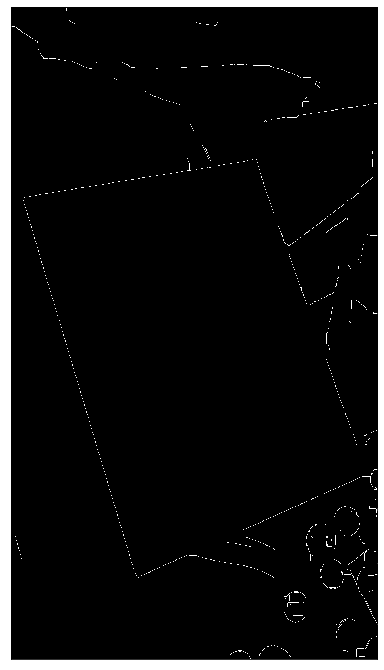

In [5]:
from skimage.filters import threshold_local
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

img=cv.imread("document.png")
def ploter(image,si=[12,12]):
    fig, ax = plt.subplots(figsize=si);ax.imshow(image,cmap='gray')
    ax.get_xaxis().set_visible(False);ax.get_yaxis().set_visible(False)
    plt.show()

gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)

kernel = np.ones((5,5),np.uint8)
dilation = cv.dilate(gray,kernel,iterations =5)
blur =cv.GaussianBlur(dilation,(3,3),0)
blur= cv.erode(blur,kernel,iterations =5)

edge=cv.Canny(blur,100,200)
ploter(edge)

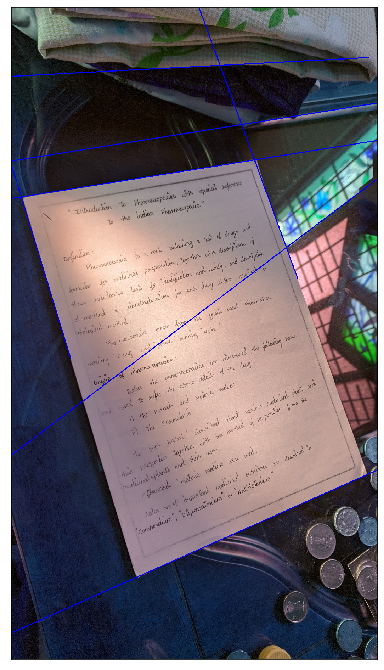

In [2]:
t=300;j=0;c=0
imgr=img.copy() 
while(j<8 and c<30):     
    try:
        linesP=cv.HoughLines(edge,1,np.pi/180,t) 
        j=linesP.shape[0]
    except:       
        j=0
    c=c+1
    t=t-10

lines=linesP.reshape(linesP.shape[0],2)
t=0;c=0;lu=[]
for l in lines:
    c=c+1;rho,theta=l
    for lt in lines[c:]:
        t=0
        if(lt[0]!=l[0]):
            rhot,thetat=lt        
            k=abs(lt-l)<[50,0.5] 
            
            if(k[0] and k[1]):
                t=-1            
                break                
    if(t==-1):  
        continue
    a = np.cos(theta);b = np.sin(theta)
    x0 = a*rho;y0 = b*rho
    x1 = int(x0 + 1000*(-b));y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b));y2 = int(y0 - 1000*(a)) 
    imgr=cv.line(imgr.copy(),(x1,y1),(x2,y2),(0,0,255),2)
    lu.append(l) 

ploter(imgr)
lr=np.asarray(lu[:4]);j=np.reshape(lr,[lr.shape[0],1,2])

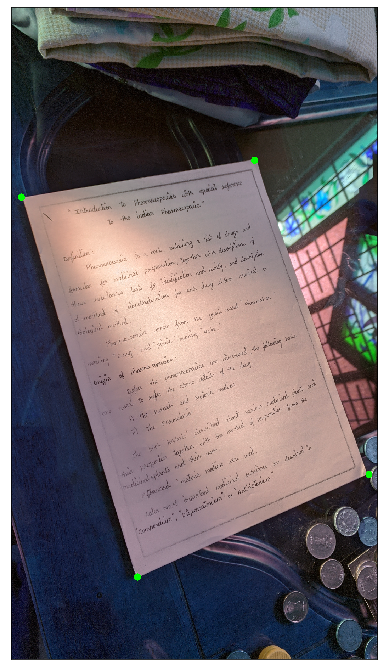

In [3]:
def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([[np.cos(theta1), np.sin(theta1)],[np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1],[rho2]])
    x0,y0=(0,0)
   
    if(abs(theta1-theta2)>1.3):
        x0, y0 = np.linalg.solve(A, b)
        x0, y0 = int(np.round(x0)), int(np.round(y0))
        
        return [[x0, y0]]
    

def intersections_finder(lines):
    intersections = []
    for i, g in enumerate(lines[:-1]):
        for g2 in lines[i+1:]:
            for line1 in g:
                for line2 in g2:
                    if(intersection(line1, line2)):
                        intersections.append(intersection(line1, line2)) 
    return intersections

intersections = intersections_finder(j)
i=np.asarray(intersections).reshape(len(intersections),2)

imgt=img.copy()
v=0;p=[]

for it in i:
    if((it[0]<0 or it[1]<0) or (it[0]>imgt.shape[1] or it[1]>imgt.shape[0])):
        continue
    p.append(it);it=tuple(it)
    imgt=cv.circle(imgt.copy(),it,10, (0, 255,0), -1) 
    
ploter(imgt)
p=np.asarray(p)

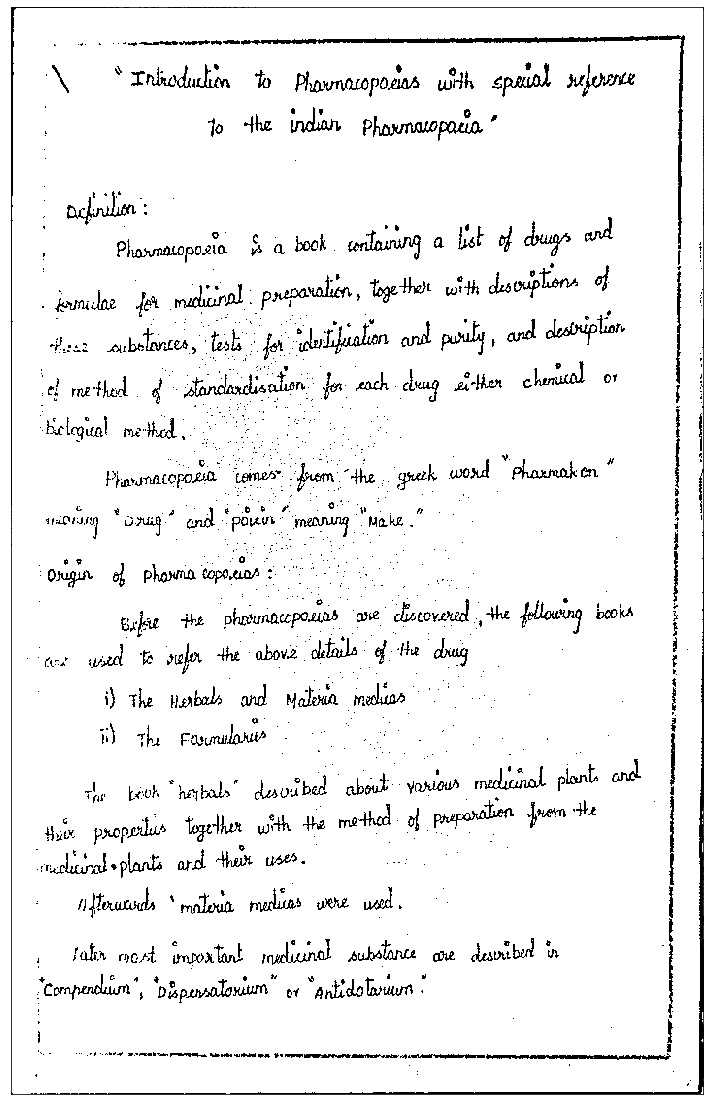

In [4]:
p = p.reshape(4,2)

r= np.zeros((4,2), dtype="float32")

s = np.sum(p, axis=1)
r[0] = p[np.argmin(s)]
r[2] = p[np.argmax(s)]

d = np.diff(p, axis=1)
r[1] = p[np.argmin(d)]
r[3] = p[np.argmax(d)]

(tl, tr, br, bl) =r

wA = np.sqrt((tl[0]-tr[0])**2 + (tl[1]-tr[1])**2 )
wB = np.sqrt((bl[0]-br[0])**2 + (bl[1]-br[1])**2 )
maxW = max(int(wA), int(wB))

hA = np.sqrt((tl[0]-bl[0])**2 + (tl[1]-bl[1])**2 )
hB = np.sqrt((tr[0]-br[0])**2 + (tr[1]-br[1])**2 )
maxH = max(int(hA), int(hB))

ds= np.array([[0,0],[maxW-1, 0],[maxW-1, maxH-1],[0, maxH-1]], dtype="float32")

transformMatrix = cv.getPerspectiveTransform(r,ds)
scan = cv.warpPerspective(gray, transformMatrix, (maxW, maxH))

T = threshold_local(scan,21, offset=10, method="gaussian")
scanBW = (scan > T).astype("uint8")* 255
ploter(scanBW,[20,20])

# cv.imwrite("document_adv_res.png",scanBW)